In [1]:
import numpy as np
import random
import math
import keras
import pandas as pd
from keras.callbacks import EarlyStopping
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, GlobalMaxPooling2D, Conv1D, Input, BatchNormalization

Using TensorFlow backend.


In [2]:
def target_row(line, rest=True):
    """filter row with GET or POST"""
    if rest:
        return line.startswith('GET') or line.startswith('POST') or line.startswith('modo=') or line.startswith('id=')
    else:
        return line.startswith('GET') or line.startswith('POST')


def read_format_1(file_name):
    """read file"""
    with open(file_name, 'r') as infile:
        data = infile.readlines()
    data = [line.strip() for line in data]
    # data = [line.lower() for line in data]
    data = [line for line in data if target_row(line)]
    r_data = []
    start_string = data[0].lower()
    for line in data[1:]:
        if target_row(line, rest=False):
            r_data.append(start_string)
            start_string = line.replace('http://localhost:8080', '').lower()
        else:
            start_string += ' ' + \
                line.replace('http://localhost:8080', '').lower()
    r_data.append(start_string)
    return r_data


def read_format_2(file_name):
    """read file"""
    with open(file_name, 'r') as infile:
        data = infile.readlines()
    data = [line.strip() for line in data]
    data = [line.lower() for line in data]
    return data

In [3]:
def generate_minibatches(x_data, y_data, batch_size):
    """generator feeding data for trainning epoch"""
    offset = 0  # offset for generate data
    while True:
        if batch_size * (offset + 1) < len(y_data):
            ims = x_data[batch_size * offset:batch_size * (offset + 1)]
            ems = y_data[batch_size * offset:batch_size * (offset + 1)]
            offset += 1
        else:
            ims = x_data[batch_size * offset:len(x_data)]
            ems = y_data[batch_size * offset:len(y_data)]
            offset = 0
        train = []
        for line in ims:
            line = line[:n_steps]
            ret_mat = np.zeros((n_steps, n_inputs))
            for idx, val in enumerate(line):
                ret_mat[idx] = np.eye(n_inputs)[val]
            train.append(ret_mat)
        train = np.asarray(train, dtype=np.int8)
        train = np.expand_dims(train, axis=-1)
        ims = train
        ems = np.asarray(ems)
        yield(ims, ems)

In [4]:
def loadData(file):
    with open(file, 'r', encoding="utf8") as f:
        data = f.readlines()
    result = []
    for d in data:
        d = d.strip()
        if (len(d) > 0):
            result.append(d)
    return result
def print_result(X_train, X_test, y_train, y_test, clf, clf_name):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    matrix = confusion_matrix(y_test, y_pred)
    TP, FP = matrix[0]
    FN, TN = matrix[1]
    PPV = (TP * 1.0) / (TP + FP)
    TPR = (TP * 1.0) / (TP + FN)
    TNR = (FP * 1.0) / (TN + FP)
    ACC = (TP + TN) * 1.0 / (TP + TN + FP + FN)
    F1 = 2.0 * PPV * TPR / (PPV + TPR)
    print("%s\t%.5f\t%.5f\t%.5f\t%.5f\t%.5f" %
          (clf_name, PPV, TPR, TNR, ACC, F1))

In [5]:
# print('[INFO] Reading data ...')
# # normal_data = read_format_2('goodqueries.txt')
# # anomalous_data = read_format_2('badqueries.txt')
# normal_data = read_format_1('normalTrafficTraining.txt')
# anomalous_data = read_format_1('anomalousTrafficTest.txt')

normal_data = loadData('normalRequestTraining.txt')
anomalous_data = loadData('anomalousRequestTest.txt')

In [6]:
print(anomalous_data[0])

gethttp://localhost:8080/tienda1/publico/anadir.jsp?id=2&nombre=jam�n+ib�rico&precio=85&cantidad=';+drop+table+usuarios;+select+*+from+datos+where+nombre+like+'%&b1=a�adir+al+carrito


In [7]:
"""create char dict constant all character appear and number match for that character"""
char_dict = {}
char_smpl = ' '.join(anomalous_data)
char_smpl = sorted(list(set(char_smpl)))
for idx, ch in enumerate(char_smpl):
    char_dict[ch] = idx
n_inputs = len(char_dict)
n_steps = 150

In [8]:
print(char_dict)

{' ': 0, '!': 1, '"': 2, '#': 3, '$': 4, '%': 5, '&': 6, "'": 7, '(': 8, ')': 9, '*': 10, '+': 11, ',': 12, '-': 13, '.': 14, '/': 15, '0': 16, '1': 17, '2': 18, '3': 19, '4': 20, '5': 21, '6': 22, '7': 23, '8': 24, '9': 25, ':': 26, ';': 27, '<': 28, '=': 29, '>': 30, '?': 31, '@': 32, '_': 33, 'a': 34, 'b': 35, 'c': 36, 'd': 37, 'e': 38, 'f': 39, 'g': 40, 'h': 41, 'i': 42, 'j': 43, 'k': 44, 'l': 45, 'm': 46, 'n': 47, 'o': 48, 'p': 49, 'q': 50, 'r': 51, 's': 52, 't': 53, 'u': 54, 'v': 55, 'w': 56, 'x': 57, 'y': 58, 'z': 59, '|': 60, '~': 61, '�': 62}


In [9]:
"""transform raw data into number according char dict"""
normal_data = [[char_dict[el] for el in line] for line in normal_data]
anomalous_data = [[char_dict[el] for el in line] for line in anomalous_data]

In [10]:
"""merge data and create target data"""
train_data = normal_data + anomalous_data
train_target = np.ones(len(normal_data)).tolist() + \
    np.zeros(len(anomalous_data)).tolist()
print('goodqueries data :', len(normal_data))
print('badqueries data :', len(anomalous_data))
print('total data :', len(train_target))

goodqueries data : 36000
badqueries data : 25065
total data : 61065


In [11]:
import matplotlib.pyplot as plt

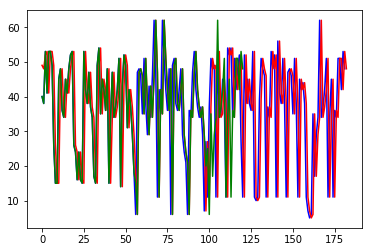

In [12]:
# for i in normal_data[:2]:
#     plt.plot(i, 'r-')
# for i in anomalous_data[:2]:
plt.plot(anomalous_data[0], 'b-')
plt.plot(anomalous_data[1], 'r-')
plt.plot(anomalous_data[2], 'g-')
plt.show()

In [13]:
"""suffle data and create validate data and test data"""
rnd_inx = list(zip(train_data, train_target))
random.shuffle(rnd_inx)
train_data, train_target = zip(*rnd_inx)

V = 6000  # number of validate set
val_data = train_data[-V:]
val_target = train_target[-V:]
train_data = train_data[:-V]
train_target = train_target[:-V]

In [14]:
"""Yoon Kim Network"""
inp = Input(shape=(n_steps, n_inputs, 1))

conv_1 = Conv2D(filters=64, kernel_size=(3, n_inputs))(inp)
actv_1 = Activation('relu')(conv_1)
btch_1 = BatchNormalization()(actv_1)
drp_1  = Dropout(0.25)(btch_1)
glmp_1 = GlobalMaxPooling2D()(drp_1)

conv_2 = Conv2D(filters=64, kernel_size=(4, n_inputs))(inp)
actv_2 = Activation('relu')(conv_2)
btch_2 = BatchNormalization()(actv_2)
drp_2  = Dropout(0.25)(btch_2)
glmp_2 = GlobalMaxPooling2D()(drp_2)

conv_3 = Conv2D(filters=64, kernel_size=(5, n_inputs))(inp)
actv_3 = Activation('relu')(conv_3)
btch_3 = BatchNormalization()(actv_3)
drp_3  = Dropout(0.25)(btch_3)
glmp_3 = GlobalMaxPooling2D()(drp_3)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [15]:
x = keras.layers.concatenate([glmp_1, glmp_2, glmp_3], axis=1)
#x = Dropout(0.25)(x)
x = Dense(96, activation='relu')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.25)(x)
out = Dense(1, activation='sigmoid')(x)

NN = Model(inputs=inp, outputs=out)
NN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
NN.summary()
batch_size = 1024
train_generator = generate_minibatches(train_data, train_target, batch_size)
val_generator = generate_minibatches(val_data, val_target, batch_size)
early_stopping = EarlyStopping(
    monitor='val_loss', min_delta=0.0001, patience=3, verbose=1, mode='auto')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 63, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 148, 1, 64)   12160       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 147, 1, 64)   16192       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 146, 1, 64)   20224       input_1[0][0]                    
__________________________________________________________________________________________________
activation

In [16]:
"""uncomment for trainning network"""
print('train data :', len(train_target))
print('validate data :', len(val_target))
print('batch size :', batch_size)
print('train steps per epoch:', math.ceil(len(train_target) / batch_size))
print('validate steps per epoch:', math.ceil(len(val_target) / batch_size))
NN.fit_generator(
    generator=train_generator,
    steps_per_epoch=math.ceil(len(train_target) / batch_size),
    epochs=100,
    verbose=1,
    validation_data=val_generator,
    validation_steps=math.ceil(len(val_target) / batch_size),
    callbacks=[early_stopping])

train data : 55065
validate data : 6000
batch size : 1024
train steps per epoch: 54
validate steps per epoch: 6
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/100
54/54 [==============================] - 385s 7s/step - loss: 0.3615 - acc: 0.8231 - val_loss: 0.1792 - val_acc: 0.9285
Epoch 2/100
29/54 [===============>..............] - ETA: 3:00 - loss: 0.1535 - acc: 0.9341

KeyboardInterrupt: 